<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/Isolation%20Forest/IsolationForest_with_differenced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

<Axes: xlabel='DT'>

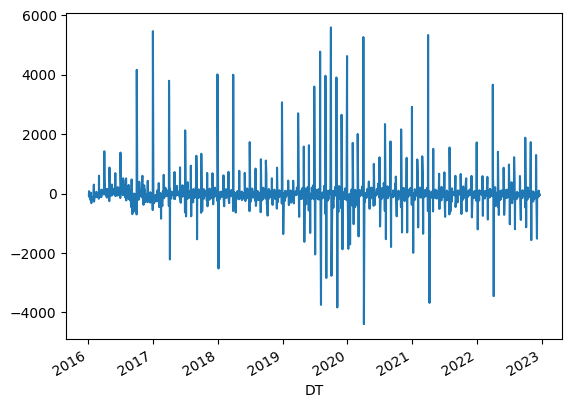

In [ ]:
df_copy = df
df_copy['ANTAL_01'] = df_copy['ANTAL_01'].astype(float) - df_copy['ANTAL_01'].astype(float).shift(1)
df_copy['ANTAL_01'].dropna().plot()

In [ ]:
df_copy.dropna()

,ANTAL_01
DT,
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0
2016-01-08,-35.0
...,...
2022-12-15,101.0
2022-12-16,-67.0
2022-12-19,-61.0


In [ ]:
model = IsolationForest()

In [ ]:
df_copy = df_copy.dropna()
print(len(df_copy))
model.fit(df_copy[['ANTAL_01']].dropna())
df_copy['ANOMALY'] = model.predict(df_copy[['ANTAL_01']].dropna())

1817


<ipython-input-24-169605f13972>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['ANOMALY'] = model.predict(df_copy[['ANTAL_01']].dropna())


In [ ]:
df_copy.reset_index(inplace=True)

In [ ]:
df_copy

,DT,ANTAL_01,ANOMALY
0,2016-01-04,-58.0,1
1,2016-01-05,82.0,1
2,2016-01-06,-113.0,1
3,2016-01-07,-41.0,1
4,2016-01-08,-35.0,1
...,...,...,...
1812,2022-12-15,101.0,1
1813,2022-12-16,-67.0,1
1814,2022-12-19,-61.0,1
1815,2022-12-20,-31.0,1


In [ ]:
#training and test
training = df_copy.iloc[:-16,:]
test = df_copy.iloc[-16:, :]
test = test.set_index('DT')
test

,ANTAL_01,ANOMALY
DT,,
2022-11-30,1301.0,-1
2022-12-01,317.0,-1
2022-12-02,-106.0,1
2022-12-05,-1516.0,-1
2022-12-06,-159.0,1
2022-12-07,-153.0,1
2022-12-08,-135.0,1
2022-12-09,-11.0,1
2022-12-12,-105.0,1


In [ ]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=training['ANOMALY'], order=(3,0,3), seasonal_order=(3,0,3,22))
result = model.fit(disp=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
exogTest = training.tail(22)
exogTest2 = exogTest.head(len(test))
exogTest2
exogvar = np.asarray(exogTest2['ANOMALY'])
exogvar = np.asarray(exogTest2['ANOMALY'])
exogvar
test_exog = pd.DataFrame(exogvar, index=test.index)
test_exog

,0
DT,
2022-11-30,-1
2022-12-01,1
2022-12-02,1
2022-12-05,-1
2022-12-06,1
2022-12-07,1
2022-12-08,1
2022-12-09,1
2022-12-12,1


In [ ]:
# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(test)-1, exog=test_exog)
pred

1801    233.568764
1802     91.795593
1803    -47.535784
1804   -101.293148
1805   -384.040228
1806    -88.057891
1807    -64.344003
1808    -97.330336
1809    -34.467423
1810    -68.541502
1811   -112.671735
1812    -44.449253
1813    -68.379428
1814    -46.705621
1815    -56.905895
1816    -69.089246
Name: predicted_mean, dtype: float64

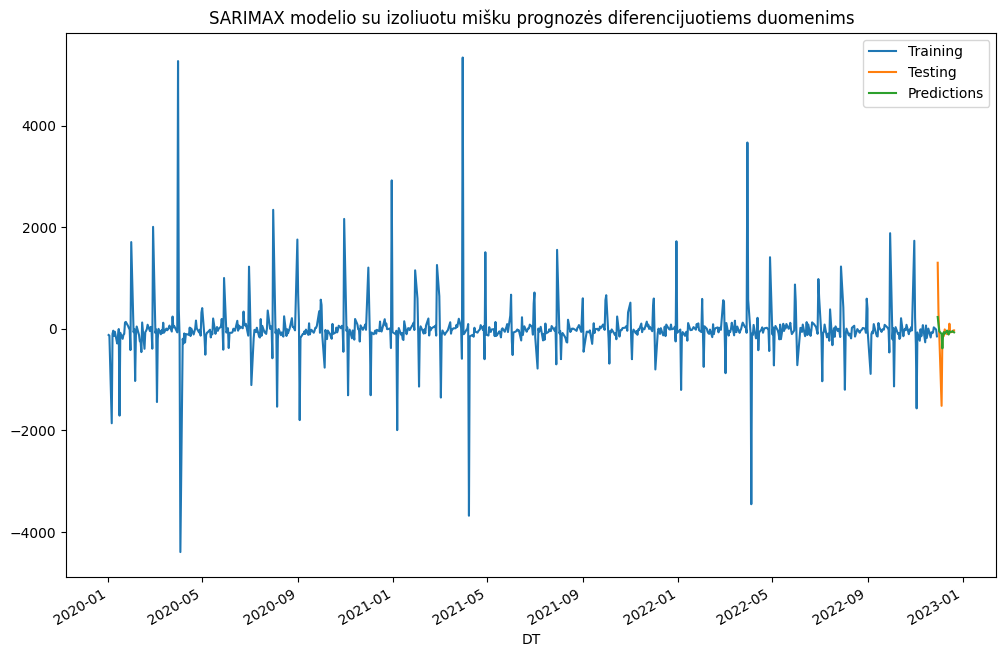

In [ ]:
predictions = pred
training.set_index('DT', inplace=True)
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
test['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = test.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su izoliuotu mišku prognozės diferencijuotiems duomenims')
plt.legend()

In [ ]:
last_values = df.iloc[:-16,:]
last_value = last_values[-1:]
last_value
original_preds= []
for pred in predictions:
    pred_value = last_value + pred
    original_preds.append(pred_value)
    last_value = pred_value
print(original_preds)

[                ANTAL_01
DT                      
2022-11-29  31139.568764,                 ANTAL_01
DT                      
2022-11-29  31231.364357,                 ANTAL_01
DT                      
2022-11-29  31183.828573,                 ANTAL_01
DT                      
2022-11-29  31082.535424,                 ANTAL_01
DT                      
2022-11-29  30698.495196,                 ANTAL_01
DT                      
2022-11-29  30610.437305,                 ANTAL_01
DT                      
2022-11-29  30546.093302,                 ANTAL_01
DT                      
2022-11-29  30448.762966,                 ANTAL_01
DT                      
2022-11-29  30414.295543,                 ANTAL_01
DT                      
2022-11-29  30345.754041,                 ANTAL_01
DT                      
2022-11-29  30233.082306,                 ANTAL_01
DT                      
2022-11-29  30188.633053,                 ANTAL_01
DT                      
2022-11-29  30120.253625,            